<a href="https://colab.research.google.com/github/mequanent/Social-Networks/blob/main/SN_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
import pydot
import time
%matplotlib inline

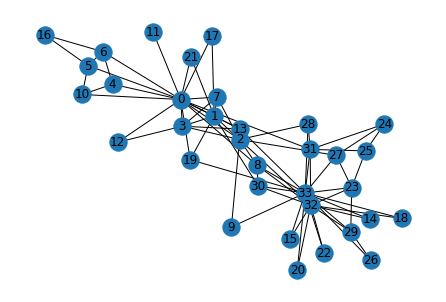

In [114]:
#@title Load the graph
G = nx.karate_club_graph()

# visualize the graph
nx.draw(G, with_labels = True)

In [ ]:
#@title Some Graph Descriptions
print("Total No. of nodes: ", G.number_of_nodes()) 
print("Total No. of edges: ", G.number_of_edges())
print(list(nx.nodes(G))) # list of nodes
print(list(G.neighbors(0)))

Total No. of nodes:  34
Total No. of edges:  78
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]


# Lab Practice

In [102]:
#@title Edges removing function 
def remove_edges(graph, edgelist):
  # remove edges
  removed_edges = list()
  for i in edgelist:
      u = list(graph.edges)[i][0]
      v = list(graph.edges)[i][1]
      removed_edges.append([u,v])
      graph.remove_edge(u,v)
  return removed_edges

In [115]:
edge_to_remove = [75, 51, 18]
removed_edges = remove_edges(G, edge_to_remove)
k = len(removed_edges)

## Similarity Coefficients 

In [116]:
#@title cn, jaccard, pref_attachment, adamic
cn = nx.common_neighbor_centrality(G) # common neighbor 
jaccard = nx.jaccard_coefficient(G) 
pref_attachment = nx.preferential_attachment(G) 
adamic = nx.adamic_adar_index(G) 

In [83]:
#@title Local Clustering Coefficient

# Addition is used in the local clustering 
def get_LCC(g):
  LCC = dict()
  for i in g.nodes:
    triangles = nx.triangles(g, i)
    k = nx.degree(g, i)
    lcc = 0
    if k > 1:
      lcc = (2* triangles) /(k*(k-1))
    LCC[i] = lcc

  lccs = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        lccs.append((u, v, LCC[u] + LCC[v])) 
  
  return lccs 

In [ ]:
#@title SimRank (TO DO)

# TO DO
def get_simRank(g):
  simRank = dict()

  for i in g.nodes:
    triangles = nx.triangles(g, i)
    k = nx.degree(g, i)
    lcc = 0
    if k > 1:
      lcc = (2* triangles) /(k*(k-1))
    simRank[i] = lcc

  return simRank


In [117]:
#@title SimRank

# get count of neighbors for a node for |I(a)| and |I(b)|
def num_neighbors(g, a):
  neighbors = [i for i in g.neighbors(a)]
  return len(neighbors)

# find the sum of the similarity of neighbors of a and b 
def sim(g, a, b, S):
  sum = 0
  for i in g.neighbors(a):
    for j in g.neighbors(b):
      sum += S[i, j] 
  return sum 

def simRnk(g):
  K = 5 
  C = 0.8 
  
  # first initialize all simiarity values to zero
  n = len(g.nodes) # number of nodes
  S = np.zeros((n, n), np.float16) # S -> nxn similarity matrix
  np.fill_diagonal(S, 1.0) # then set S(a, b) = 1 for a == b

  for k in range(K): 
    for a in range(n): 
      I_a = num_neighbors(g, a) 
      for b in range(n): 
        I_b = num_neighbors(g, b) 
        if a == b:
          S[a, b], S[b, a] = 1.0, 1.0
        else:
          S[a, b] = C / (I_a*I_b) * sim(g, a, b, S)
          #simR[b, a] = simR[a, b] 
  return S  

def simRank(g):
  simR = simRnk(g)
  simRank = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        simRank.append((u, v, simR[u, v])) 
  
  return simRank  

In [121]:
xp = np.zeros((4,4))
for i in range(4):
  for j in range(i, 4):
    #print((i, j), "|", (j, i))
    if i == j:
      xp[i, j] = 1
xp

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [118]:
#@title Sort the coefficients 
lccs =  get_LCC(G)
simRanks = simRank(G)

# sort the coefficients  
sorted_cn = sorted(cn, key=lambda tup: tup[2], reverse=True)
sorted_jaccard = sorted(jaccard, key=lambda tup: tup[2], reverse=True)
sorted_adamic = sorted(adamic, key=lambda tup: tup[2], reverse=True)
sorted_pref_attachment = sorted(pref_attachment, key=lambda tup: tup[2], reverse=True)
sorted_lcc = sorted(lccs, key=lambda tup: tup[2], reverse=True)
sorted_simRank = sorted(simRanks, key=lambda tup: tup[2], reverse=True)

## Evaluation Metrics

In [9]:
#@title Mean Rank (MR)
def MR(sorted_tuple):
  rank_cn = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank_cn += idx
      idx += 1
  return rank_cn/k

In [10]:
#@title Mean Reciprocal Rank (MRR)
def MRR(sorted_tuple):
  rank_cn = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank_cn += 1/(idx+1) # 1/(idx +1)
      idx += 1
  return rank_cn/k

In [11]:
#@title Hit@N
def hitN(sorted_tuple, N):
  hits = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
        if idx < N:
          hits += 1 
      idx += 1
  return hits

In [119]:
#@title Display Function

# display metrics and the time to compute all of them together
def display_metrics(coef, title):
  start = time.time()
  print(title)
  print("MR: ", MR(coef))
  print("MRR: ", MRR(coef))
  print("Hit@100: ", hitN(coef, 100))
  end = time.time()
  print("Time %f seconds" % (end-start))
  print("\n")

In [120]:
#@title Display metrics of coefficients
# sorted_cn, sorted_jaccard, sorted_adamic, sorted_pref_attachment, sorted_lcc
display_metrics(sorted_cn, "Common Neighbor")
display_metrics(sorted_jaccard, "Jaccard Coefficient")
display_metrics(sorted_adamic, "Adamic/Adar")
display_metrics(sorted_pref_attachment, "Preferential Attachment ")
display_metrics(sorted_lcc, "Local Clustering Coefficient with Addition")
display_metrics(sorted_simRank, "SimRank")

Common Neighbor
MR:  160.0
MRR:  0.11390640802405506
Hit@100:  1
Time 0.001873 seconds


Jaccard Coefficient
MR:  184.33333333333334
MRR:  0.009301753947423238
Hit@100:  1
Time 0.000712 seconds


Adamic/Adar
MR:  131.0
MRR:  0.03173144573144573
Hit@100:  1
Time 0.000616 seconds


Preferential Attachment 
MR:  74.0
MRR:  0.029221522292215224
Hit@100:  2
Time 0.008814 seconds


Local Clustering Coefficient with Addition
MR:  370.3333333333333
MRR:  0.0032556723687336662
Hit@100:  0
Time 0.000560 seconds


SimRank
MR:  174.66666666666666
MRR:  0.00653961674776236
Hit@100:  1
Time 0.007094 seconds




# Home work